In [1]:
# #  installations
!pip install transformers
!pip install datasets
!pip install torch
!pip install numpy
!pip install tqdm
!pip install pandas
!pip install evaluate rouge_score sacrebleu bert_score

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=97163a84a40dca155b338b291d305da9784e9b3a9054d62607da82f3dd1cd75e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.0 MB/s eta 0:00:00


In [3]:
# mkdir bart-model
# mkdir t5-model

## Imports

In [4]:
import pandas as pd
import numpy as np
import re
import contractions
import evaluate
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import bert_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BartForConditionalGeneration,
    BartTokenizer,
    T5ForConditionalGeneration,
    T5Tokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Preprocessing 

In [5]:
ABBREVIATIONS = {
    # General
    "a.k.a.": "also known as",
    "a.m.": "ante meridiem",
    "aka": "also known as",
    "approx.": "approximately",
    "appt.": "appointment",
    "asap": "as soon as possible",
    "aug.": "august",
    "avg.": "average",
    "co.": "company",
    "corp.": "corporation",
    "dec.": "december",
    "dept.": "department",
    "dr.": "doctor",
    "e.g.": "for example",
    "esp.": "especially",
    "est.": "established",
    "etc.": "et cetera",
    "feb.": "february",
    "fig.": "figure",
    "gov.": "governor",
    "govt.": "government",
    "i.e.": "that is",
    "inc.": "incorporated",
    "jan.": "january",
    "jr.": "junior",
    "jul.": "july",
    "jun.": "june",
    "mar.": "march",
    "max.": "maximum",
    "min.": "minutes",
    "misc.": "miscellaneous",
    "mr.": "mister",
    "mrs.": "mistress",
    "ms.": "miss",
    "no.": "number",
    "nov.": "november",
    "oct.": "october",
    "p.m.": "post meridiem",
    "pp.": "pages",
    "rev.": "revision",
    "rsvp": "please respond",
    "sep.": "september",
    "sr.": "senior",
    "stmt.": "statement",
    "temp.": "temperature",
    "vol.": "volume",
    "vs.": "versus",

    # Business & Titles
    "acct.": "account",
    "b2b": "business to business",
    "b2c": "business to consumer",
    "ceo": "chief executive officer",
    "cfo": "chief financial officer",
    "cio": "chief information officer",
    "cli": "command line interface",
    "cob": "close of business",
    "coo": "chief operating officer",
    "cto": "chief technology officer",
    "dir.": "director",
    "eod": "end of day",
    "eta": "estimated time of arrival",
    "hr": "human resources",
    "kpi": "key performance indicator",
    "ltd.": "limited",
    "mgr.": "manager",
    "nda": "non disclosure agreement",
    "poc": "point of contact",
    "pr": "public relations",
    "qa": "quality assurance",
    "r&d": "research and development",
    "roi": "return on investment",
    "vp": "vice president",

    # Legal
    "adj.": "adjourned",
    "aff.": "affidavit",
    "att.": "attorney",
    "def.": "defendant",
    "exh.": "exhibit",
    "hrg.": "hearing",
    "pltf.": "plaintiff",
    "v.": "versus",

    # Military
    "adm.": "admiral",
    "cmdr.": "commander",
    "col.": "colonel",
    "cpt.": "captain",
    "gen.": "general",
    "jnr.": "junior",
    "lt.": "lieutenant",
    "maj.": "major",
    "mil.": "military",
    "pvt.": "private",
    "sgt.": "sergeant",
    "snr.": "senior",

    # Time / Units / Math
    "cm": "centimeter",
    "cu.": "cubic",
    "eq.": "equation",
    "ft": "feet",
    "hrs": "hours",
    "in": "inch",
    "kg": "kilogram",
    "km": "kilometer",
    "kph": "kilometers per hour",
    "lb": "pound",
    "mg": "milligram",
    "min": "minute",
    "ml": "milliliter",
    "mod.": "modulo",
    "mph": "miles per hour",
    "oz": "ounce",
    "sec": "second",
    "sq.": "square",
    "°c": "degrees celsius",
    "°f": "degrees fahrenheit",

    # Tech / Computing
    "api": "application programming interface",
    "cpu": "central processing unit",
    "css": "cascading style sheets",
    "db": "database",
    "dbms": "database management system",
    "gpu": "graphics processing unit",
    "html": "hypertext markup language",
    "http": "hypertext transfer protocol",
    "https": "hypertext transfer protocol secure",
    "ide": "integrated development environment",
    "ip": "internet protocol",
    "js": "javascript",
    "os": "operating system",
    "ram": "random access memory",
    "sql": "structured query language",
    "ssd": "solid state drive",
    "ui": "user interface",
    "usb": "universal serial bus",
    "ux": "user experience",
    "www": "world wide web",

    # Science / Medical
    "aids": "acquired immunodeficiency syndrome",
    "bp": "blood pressure",
    "ct": "computed tomography",
    "dna": "deoxyribonucleic acid",
    "er": "emergency room",
    "hiv": "human immunodeficiency virus",
    "icd": "international classification of diseases",
    "icu": "intensive care unit",
    "meds": "medications",
    "mri": "magnetic resonance imaging",
    "otc": "over the counter",
    "pt": "patient",
    "rna": "ribonucleic acid",
    "rx": "prescription",

    # Internet / Slang
    "afaik": "as far as i know",
    "atm": "at the moment",
    "brb": "be right back",
    "btw": "by the way",
    "dm": "direct message",
    "fyi": "for your information",
    "idk": "i do not know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "irl": "in real life",
    "lmao": "laughing my ass off",
    "lol": "laugh out loud",
    "np": "no problem",
    "nsfw": "not safe for work",
    "omg": "oh my god",
    "smh": "shaking my head",
    "tbd": "to be determined",
    "tbh": "to be honest",
    "thx": "thanks",
    "ty": "thank you",
    "wtf": "what the heck",
    "yw": "you are welcome",
}

def expand_abbreviations(text):
    for abbr, full_form in ABBREVIATIONS.items():
        text = re.sub(r'\b' + re.escape(abbr) + r'\b', full_form, text, flags=re.IGNORECASE)
    return text

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def clean_text_alternative(text):
    text = remove_urls(text)
    text = contractions.fix(text)
    
    text = expand_abbreviations(text)
    
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", "", text)
    
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data_path = "/kaggle/input/clan-datas/CLAN_data.csv"
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"File not found at {data_path}. Please check the file path.")
    exit(0)

print("Original Data:")
print(df.head(5))

df['post'] = df['Social Media Post'].apply(clean_text_alternative)

print("\nPreprocessed Data:")
print(df[['Social Media Post', 'post']].head(5))


Original Data:
   PID                                  Social Media Post  \
0    1  President \n @realDonaldTrump\n : "Biden's pla...   
1    2  IMPORTANT ANNOUNCEMENT - CORONAVIRUS\nLast eve...   
2    3                         Heart is delighted to hear   
3    4  An allowed appeal is one where the initial ref...   
4    5  WARM WATER THERAPY\nDr. D. Mensah Asare says t...   

                                    Normalized Claim  
0  Biden’s energy plan would get rid of seniors’ ...  
1  If someone with the new coronavirus sneezes, i...  
2                         Heart is delighted to hear  
3  The vast majority of people coming across the ...  
4  A widely popular social media post claims that...  

Preprocessed Data:
                                   Social Media Post  \
0  President \n @realDonaldTrump\n : "Biden's pla...   
1  IMPORTANT ANNOUNCEMENT - CORONAVIRUS\nLast eve...   
2                         Heart is delighted to hear   
3  An allowed appeal is one where the initia

## spliting the dataset

In [6]:
data_path = "/kaggle/input/preprocessed-data/preprocessed_CLAN_data.csv"
df = pd.read_csv(data_path)

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 1967
Validation set size: 422
Test set size: 422


## Data Set and plot functions 

In [7]:
def plot_train_val_loss_from_trainer(trainer):
    log_history = trainer.state.log_history

    train_steps, train_losses = [], []
    eval_steps, eval_losses = [], []

    for entry in log_history:
        if "loss" in entry and "step" in entry:
            train_steps.append(entry["step"])
            train_losses.append(entry["loss"])
        if "eval_loss" in entry and "step" in entry:
            eval_steps.append(entry["step"])
            eval_losses.append(entry["eval_loss"])

    plt.figure(figsize=(10, 6))
    if train_steps:
        plt.plot(train_steps, train_losses, label="Train Loss", marker="o")
    if eval_steps:
        plt.plot(eval_steps, eval_losses, label="Validation Loss", marker="o")

    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


class CLANDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_col, target_col, max_len=256, prefix=""):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.source_col = source_col
        self.target_col = target_col
        self.max_len = max_len
        self.prefix = prefix  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        source_text = str(self.data.iloc[index][self.source_col])
        target_text = str(self.data.iloc[index][self.target_col])

        if self.prefix:
            source_text = f"{self.prefix} {source_text}"
        
        source = self.tokenizer(
            source_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        target = self.tokenizer(
            target_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        
        labels = target["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100  

        return {
            "input_ids": source["input_ids"].squeeze(),
            "attention_mask": source["attention_mask"].squeeze(),
            "labels": labels,
        }

# Bart
### Training


In [8]:
model_name = "facebook/bart-large"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

train_dataset = CLANDataset(train_df, tokenizer, source_col="post", target_col="Normalized Claim")
val_dataset = CLANDataset(val_df, tokenizer, source_col="post", target_col="Normalized Claim")

training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/bart-model",
    logging_dir="/kaggle/working/bart-model",
    eval_strategy="epoch", 
    learning_rate=1e-5,              
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=11,           
    weight_decay=0.04,             
    predict_with_generate=True,  
    logging_steps=50,
    save_total_limit=2,
    report_to="none", 
    gradient_accumulation_steps=2,
    warmup_steps=500,
)

 
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
) 

trainer.train()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

<ipython-input-8-e6804f4f7455>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,4.800500,3.851592
2,3.555600,2.654464
3,2.965900,2.499713
4,2.701100,2.380991
5,2.452600,2.316355
6,2.326000,2.274523
7,2.194500,2.239465
8,2.105000,2.224252
9,1.930400,2.176485
10,1.767600,2.177034


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=671, training_loss=2.5256668750291076, metrics={'train_runtime': 2872.4293, 'train_samples_per_second': 7.533, 'train_steps_per_second': 0.234, 'total_flos': 1.1540915558547456e+16, 'train_loss': 2.5256668750291076, 'epoch': 10.829268292682928})

### saving the model


In [9]:
# Save the fine-tuned model and tokenizer
trainer.save_model("/kaggle/working/bart-model")
tokenizer.save_pretrained("/kaggle/working/bart-model")

('/kaggle/working/bart-model/tokenizer_config.json',
 '/kaggle/working/bart-model/special_tokens_map.json',
 '/kaggle/working/bart-model/vocab.json',
 '/kaggle/working/bart-model/merges.txt',
 '/kaggle/working/bart-model/added_tokens.json')

### Evaluating it on test set
    

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/kaggle/working/bart-model"
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)
model.to(device)

test_dataset = CLANDataset(test_df, tokenizer, source_col="post", target_col="Normalized Claim")
test_loader = DataLoader(test_dataset, batch_size=8)


rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bert_Score = evaluate.load("bertscore")


model.eval()
predictions = []
references = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Generate predictions
        outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_length=512,
    num_beams=4,         
    early_stopping=True,
    min_length=5         
)
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Decode references (filter out padding tokens)
        decoded_refs = [
            tokenizer.decode(label[label != -100], skip_special_tokens=True)
            for label in labels
        ]

        predictions.extend(decoded_preds)
        references.extend([[ref] for ref in decoded_refs])  # BLEU expects a list of references


In [11]:
if isinstance(references[0], list):
    references = [ref[0] for ref in references]

#  BLEU-4 
def compute_bleu_score(predictions, list_of_refs):
    smoothie = SmoothingFunction().method4
    total_score = 0.0

    for pred, ref_list in zip(predictions, list_of_refs):
        pred_tokens = pred.split()
        tokenized_refs = [r.split() for r in ref_list]
        score = sentence_bleu(
            tokenized_refs,
            pred_tokens,
            smoothing_function=smoothie,
            weights=(0.25, 0.25, 0.25, 0.25)  
        )
        total_score += score

    return total_score / len(predictions)


#  ROUGE-L 
def compute_rouge_l(predictions, references):
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    total_f1 = 0.0

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        total_f1 += scores["rougeL"].fmeasure

    return total_f1 / len(predictions)


# BERTScore
def compute_bertscore(predictions, references, model_type="roberta-large"):
    P, R, F = bert_score.score(predictions, references, model_type=model_type, lang="en")
    avg_f1 = float(torch.mean(F))
    return avg_f1


bleu_refs = [[ref] for ref in references] 

bleu_4 = compute_bleu_score(predictions, bleu_refs)
rouge_l = compute_rouge_l(predictions, references)
bert_f1 = compute_bertscore(predictions, references)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Results

In [12]:
print(f"BLEU-4: {bleu_4:.4f}")
print(f"ROUGE-L: {rouge_l:.4f}")
print(f"BERTScore (F1): {bert_f1:.4f}")

BLEU-4: 0.2160
ROUGE-L: 0.3578
BERTScore (F1): 0.8844


### Plot


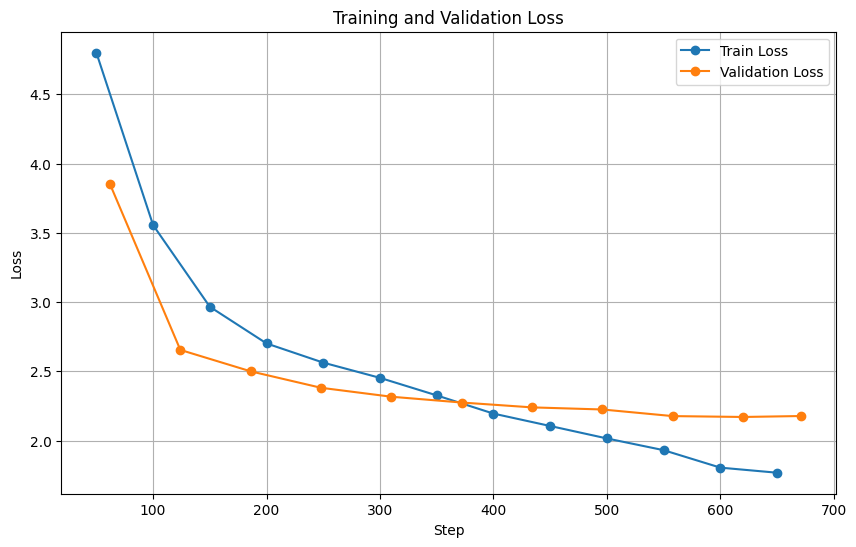

In [13]:
# Call this function after training:
plot_train_val_loss_from_trainer(trainer)

# T5
### Training

In [14]:
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


prefix_text = "normalize claim:" 


train_dataset = CLANDataset(train_df, tokenizer, source_col="post", target_col="Normalized Claim", prefix=prefix_text)
val_dataset = CLANDataset(val_df, tokenizer, source_col="post", target_col="Normalized Claim", prefix=prefix_text)


training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/t5-model",
    logging_dir="/kaggle/working/t5-model",
    eval_strategy="epoch",       
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=12,
    weight_decay=0.01,
    predict_with_generate=True,  
    logging_steps=50,
    save_total_limit=2,
    report_to="none", 
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<ipython-input-14-ae754ef3b920>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.974700,2.853813
2,2.874700,2.698667
3,2.667100,2.615608
4,2.678200,2.560776
5,2.521000,2.524452
6,2.412000,2.499813
7,2.383200,2.483185
8,2.598100,2.470629
9,2.466200,2.463067
10,2.371600,2.457050


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=2952, training_loss=2.576078256132803, metrics={'train_runtime': 2538.708, 'train_samples_per_second': 9.298, 'train_steps_per_second': 1.163, 'total_flos': 7186921024389120.0, 'train_loss': 2.576078256132803, 'epoch': 12.0})

### Saving the model and tokenizer

In [15]:
# Save the fine-tuned model and tokenizer
trainer.save_model("/kaggle/working/t5-model")
tokenizer.save_pretrained("/kaggle/working/t5-model")

('/kaggle/working/t5-model/tokenizer_config.json',
 '/kaggle/working/t5-model/special_tokens_map.json',
 '/kaggle/working/t5-model/spiece.model',
 '/kaggle/working/t5-model/added_tokens.json')

### Evalutating it on test set

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/kaggle/working/t5-model"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.to(device)


test_dataset = CLANDataset(test_df, tokenizer, source_col="post", target_col="Normalized Claim")
test_loader = DataLoader(test_dataset, batch_size=8)


rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bert_Score = evaluate.load("bertscore")


model.eval()
predictions = []
references = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Generate predictions
        outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_length=512,
    num_beams=4,          
    early_stopping=True,
    min_length=5          
)
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        decoded_refs = [
            tokenizer.decode(label[label != -100], skip_special_tokens=True)
            for label in labels
        ]

        predictions.extend(decoded_preds)
        references.extend([[ref] for ref in decoded_refs])  # BLEU expects a list of references


In [17]:
if isinstance(references[0], list):
    references = [ref[0] for ref in references]
#  BLEU-4 
def compute_bleu_score(predictions, list_of_refs):
    smoothie = SmoothingFunction().method4
    total_score = 0.0

    for pred, ref_list in zip(predictions, list_of_refs):
        pred_tokens = pred.split()
        tokenized_refs = [r.split() for r in ref_list]  
        score = sentence_bleu(
            tokenized_refs,
            pred_tokens,
            smoothing_function=smoothie,
            weights=(0.25, 0.25, 0.25, 0.25)  
        )
        total_score += score

    return total_score / len(predictions)


# ROUGE-L 
def compute_rouge_l(predictions, references):
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    total_f1 = 0.0

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        total_f1 += scores["rougeL"].fmeasure

    return total_f1 / len(predictions)


# BERTScore 
def compute_bertscore(predictions, references, model_type="roberta-large"):
    P, R, F = bert_score.score(predictions, references, model_type=model_type, lang="en")
    avg_f1 = float(torch.mean(F))
    return avg_f1


bleu_refs = [[ref] for ref in references]  

bleu_4 = compute_bleu_score(predictions, bleu_refs)
rouge_l = compute_rouge_l(predictions, references)
bert_f1 = compute_bertscore(predictions, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Results


In [18]:
print(f"BLEU-4: {bleu_4:.4f}")
print(f"ROUGE-L: {rouge_l:.4f}")
print(f"BERTScore (F1): {bert_f1:.4f}")

BLEU-4: 0.1996
ROUGE-L: 0.3202
BERTScore (F1): 0.8604


### Plot


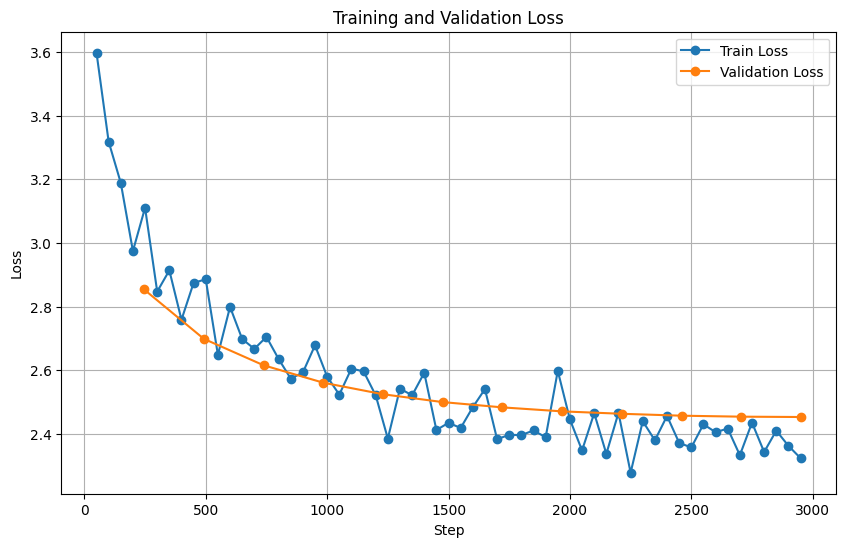

In [19]:
plot_train_val_loss_from_trainer(trainer)